In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timeit import default_timer
from tqdm import tqdm

In [7]:
# Model specifications

v0 = torch.tensor([2.0]) # Velocity at the origin of the model

vergrad = torch.tensor([0.5]) # Vertical gradient
horgrad = torch.tensor([0.0]) # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 3.; deltax = 0.02;

In [8]:
# Synthetic source locations

spacing = 0.05

sx = np.arange( 0.5, 2.5+spacing, spacing )
sz = np.arange( 1, 1.75+spacing, spacing )

num_of_data = len(sz) * len(sx) # Number of training points

cord = np.meshgrid( sx,sz )

print(f'size of data set:{num_of_data}')
print(f'For Z coordinates:{np.shape(sz)}')
print(f'For X coordinates:{np.shape(sx)}')
print(f'Whole grid :{np.shape(cord)}')

cord[1] = np.round(cord[1],2)
cord[0] = np.round(cord[0],2)
cord_x = cord[0]
cord_z = cord[1]

size of data set:656
For Z coordinates:(16,)
For X coordinates:(41,)
Whole grid :(2, 16, 41)


In [22]:
# Creating grid

z = torch.arange( zmin, zmax + deltaz, deltaz )
nz = z.shape[0]

x = torch.arange( xmin, xmax + deltax, deltax )
nx = x.shape[0]

Z, X = torch.meshgrid( z, x, indexing='ij' )

# Preparing velocity model
velmodel = v0 + vergrad * Z + horgrad * X

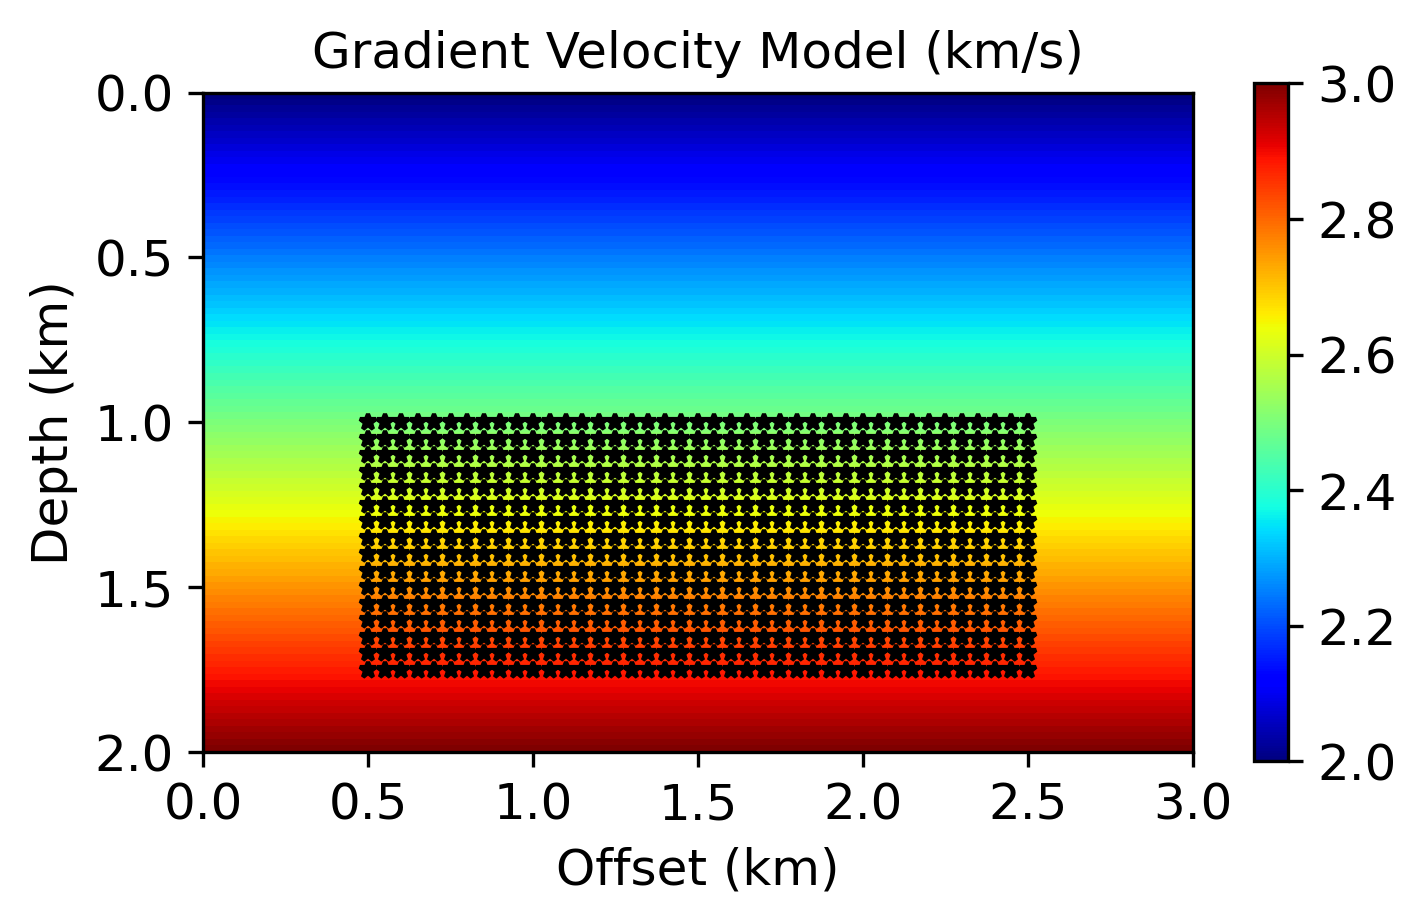

In [12]:
# Plot the velocity model with the source locations

fsize = 12

plt.figure(figsize=(5,3), dpi=300)

im = plt.imshow(velmodel, cmap='jet',aspect=1, extent=[0, 3, 2, 0])

cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=fsize)

plt.plot(cord_x, cord_z, 'k*', markersize=4)

# Add labels and title
plt.xlabel('Offset (km)',size = fsize)
plt.ylabel('Depth (km)',size = fsize)
plt.title('Gradient Velocity Model (km/s)',size = fsize)

plt.yticks(np.arange(0, 2.5, 0.5))

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'gradient_velmodel.pdf' , dpi=300)

plt.show()

In [23]:
# Generate train set with traveltime solutions

y_train = torch.zeros(size=( num_of_data, nz, nx ))
x_train = torch.zeros(size=( num_of_data, 1, nx ))

n = 0 
k = 0

while k <= (num_of_data):    
    for i in range(len(sz)):
        for j in range(len(sx)):

            vs = v0 + vergrad*cord_z[i][j] + horgrad*cord_x[i][j]    # velocity at the source location
            
            # for homogenous velocity model  
            if vergrad == 0 and horgrad == 0:
                                  
                T_data = torch.sqrt((Z - cord_z[i][j])**2 + (X - cord_x[i][j])**2) / v0
                
            else:
                # for velocity gradient model
                T_data = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*
                                      ((X-cord_x[i][j])**2 + (Z-cord_z[i][j])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
       
            x_train[k : :] = T_data[0]
            y_train[k : :] = T_data
        
            k = k + 1   

x_train = x_train.repeat( 1, nz, 1 )

print(np.shape(x_train))
print(np.shape(y_train))

torch.Size([656, 101, 151])
torch.Size([656, 101, 151])


In [24]:
# Generate test set with traveltime solutions

cord_z_test = np.random.uniform(1,1.75, size=(50))
cord_x_test = np.random.uniform(0.5,2.5, size=(50))

y_test = torch.zeros([len(cord_z_test),nz,nx])
x_test = torch.zeros([len(cord_z_test),1,nx])

n = 0 
k = 0

while k <= (len(cord_z_test)):
    for i in range( len( cord_z_test ) ):
         
        vs = v0 + vergrad*cord_z_test[i] + horgrad*cord_x_test[i]    # velocity at the source location

        # for homogenous velocity model  
        if vergrad == 0 and horgrad == 0:
                              
            T_data = torch.sqrt((Z - cord_z_test[i])**2 + (X - cord_x_test[i])**2) / v0
            
        else:
            # for velocity gradient model
            T_data = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*
                                  ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
    
        x_test[k : :] = T_data[0]
        y_test[k : :] = T_data
    
        k = k + 1    

x_test = x_test.repeat( 1, nz, 1 )

print(np.shape(x_test))
print(np.shape(y_test))

torch.Size([50, 101, 151])
torch.Size([50, 101, 151])


In [25]:
x_train = x_train.reshape( len(x_train), nz, nx, 1 )
x_test = x_test.reshape( len(x_test), nz, nx, 1 )

In [26]:
print(f'Input size of training data: {np.shape(x_train)}')
print(f'Input size of testing data: {np.shape(x_test)}')

print('--'*50)

print(f'output size of training data: {np.shape(y_train)}')
print(f'output size of testing data: {np.shape(y_test)}')

Input size of training data: torch.Size([656, 101, 151, 1])
Input size of testing data: torch.Size([50, 101, 151, 1])
----------------------------------------------------------------------------------------------------
output size of training data: torch.Size([656, 101, 151])
output size of testing data: torch.Size([50, 101, 151])


In [27]:
x_test = x_test.type('torch.FloatTensor')
y_test = y_test.type('torch.FloatTensor')
y_train =  y_train.type('torch.FloatTensor')
x_train = x_train.type('torch.FloatTensor')

In [28]:
batch_size = 1

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [29]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [31]:
modes = 2
width = 2

model = FNO2d(modes, modes, width).cuda()

In [69]:
# Loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [70]:
learning_rate = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

myloss = LpLoss(size_average=False)

patience = 50  # Number of epochs to wait before stopping

In [74]:
# To save the model

model_name = 'Model_gradient_'+str(int(spacing*1000))+'m_train_m'+str(modes)+'w'+str(width)+'_best.pt'

model_name

'Model_gradient_50m_train_m2w2_best.pt'

In [ ]:
# Model training 

start_training = default_timer()

epochs = 1000

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
best_val_loss = float('inf')
trigger_times = 0  # Counter for early stopping

for ep in tqdm(range(1,epochs+1)):
    
    model.train()
    t1 = default_timer()
    train_l2 = 0
    
    for x, y in train_loader:
        
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape( batch_size, nz, nx )

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    train_l2 /= len(x_train)
    train_loss[ep-1] = train_l2

    scheduler.step( train_l2 ) # Update learning rate with average of train events

    # Early stopping logic
    if train_l2 < best_val_loss:
        
        best_val_loss = train_l2
        trigger_times = 0  # Reset the counter if validation loss improves
        
        # Optionally, save the model with the best validation loss
        torch.save( model.state_dict(), model_name )
        
    else:
        
        trigger_times += 1
        
        if trigger_times >= patience:
            
            print(f"Early stopping at epoch {ep}")
            break  # Stop training if validation loss hasn't improved in 'patience' epochs


    
    model.eval()
    test_l2 = 0.0
      
    with torch.no_grad():
            
        for x, y in test_loader:
            
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape( batch_size, nz, nx )

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
                
    test_l2 /= len(x_test)
    test_loss[ep-1] = test_l2

    t2 = default_timer()
    
    print(f'Epoch:{ep} \n Training time for  epoch {ep}: {round((t2-t1)/60,3)} minutes,Training loss:  {train_l2}, Testing loss: {test_l2}')

    if (ep+1) % 50 == 0:
    
        # Loss Figure
        fig = plt.figure( figsize=(5, 3), dpi=300 )
        ax = plt.axes()
            
        ax.semilogy(test_loss, linewidth=2, label = 'Test loss')
        ax.semilogy(train_loss , linewidth=2, label = 'Training loss', color = 'orange')
        ax.set_xlabel('Epochs', fontsize=10)
        plt.xticks(fontsize=10)
        ax.xaxis.set_major_locator(plt.MultipleLocator(100))        
        ax.set_ylabel('Loss', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid()
        plt.legend(loc='upper right')
        plt.title('Comparison of Training and test losses')
        plt.show()

end = default_timer() - start_training

if end > 3600:
    print(f'Total training time {round(end/3600,3)} hours')
else:
    print(f'Total training time {round(end/60,3)} minutes')

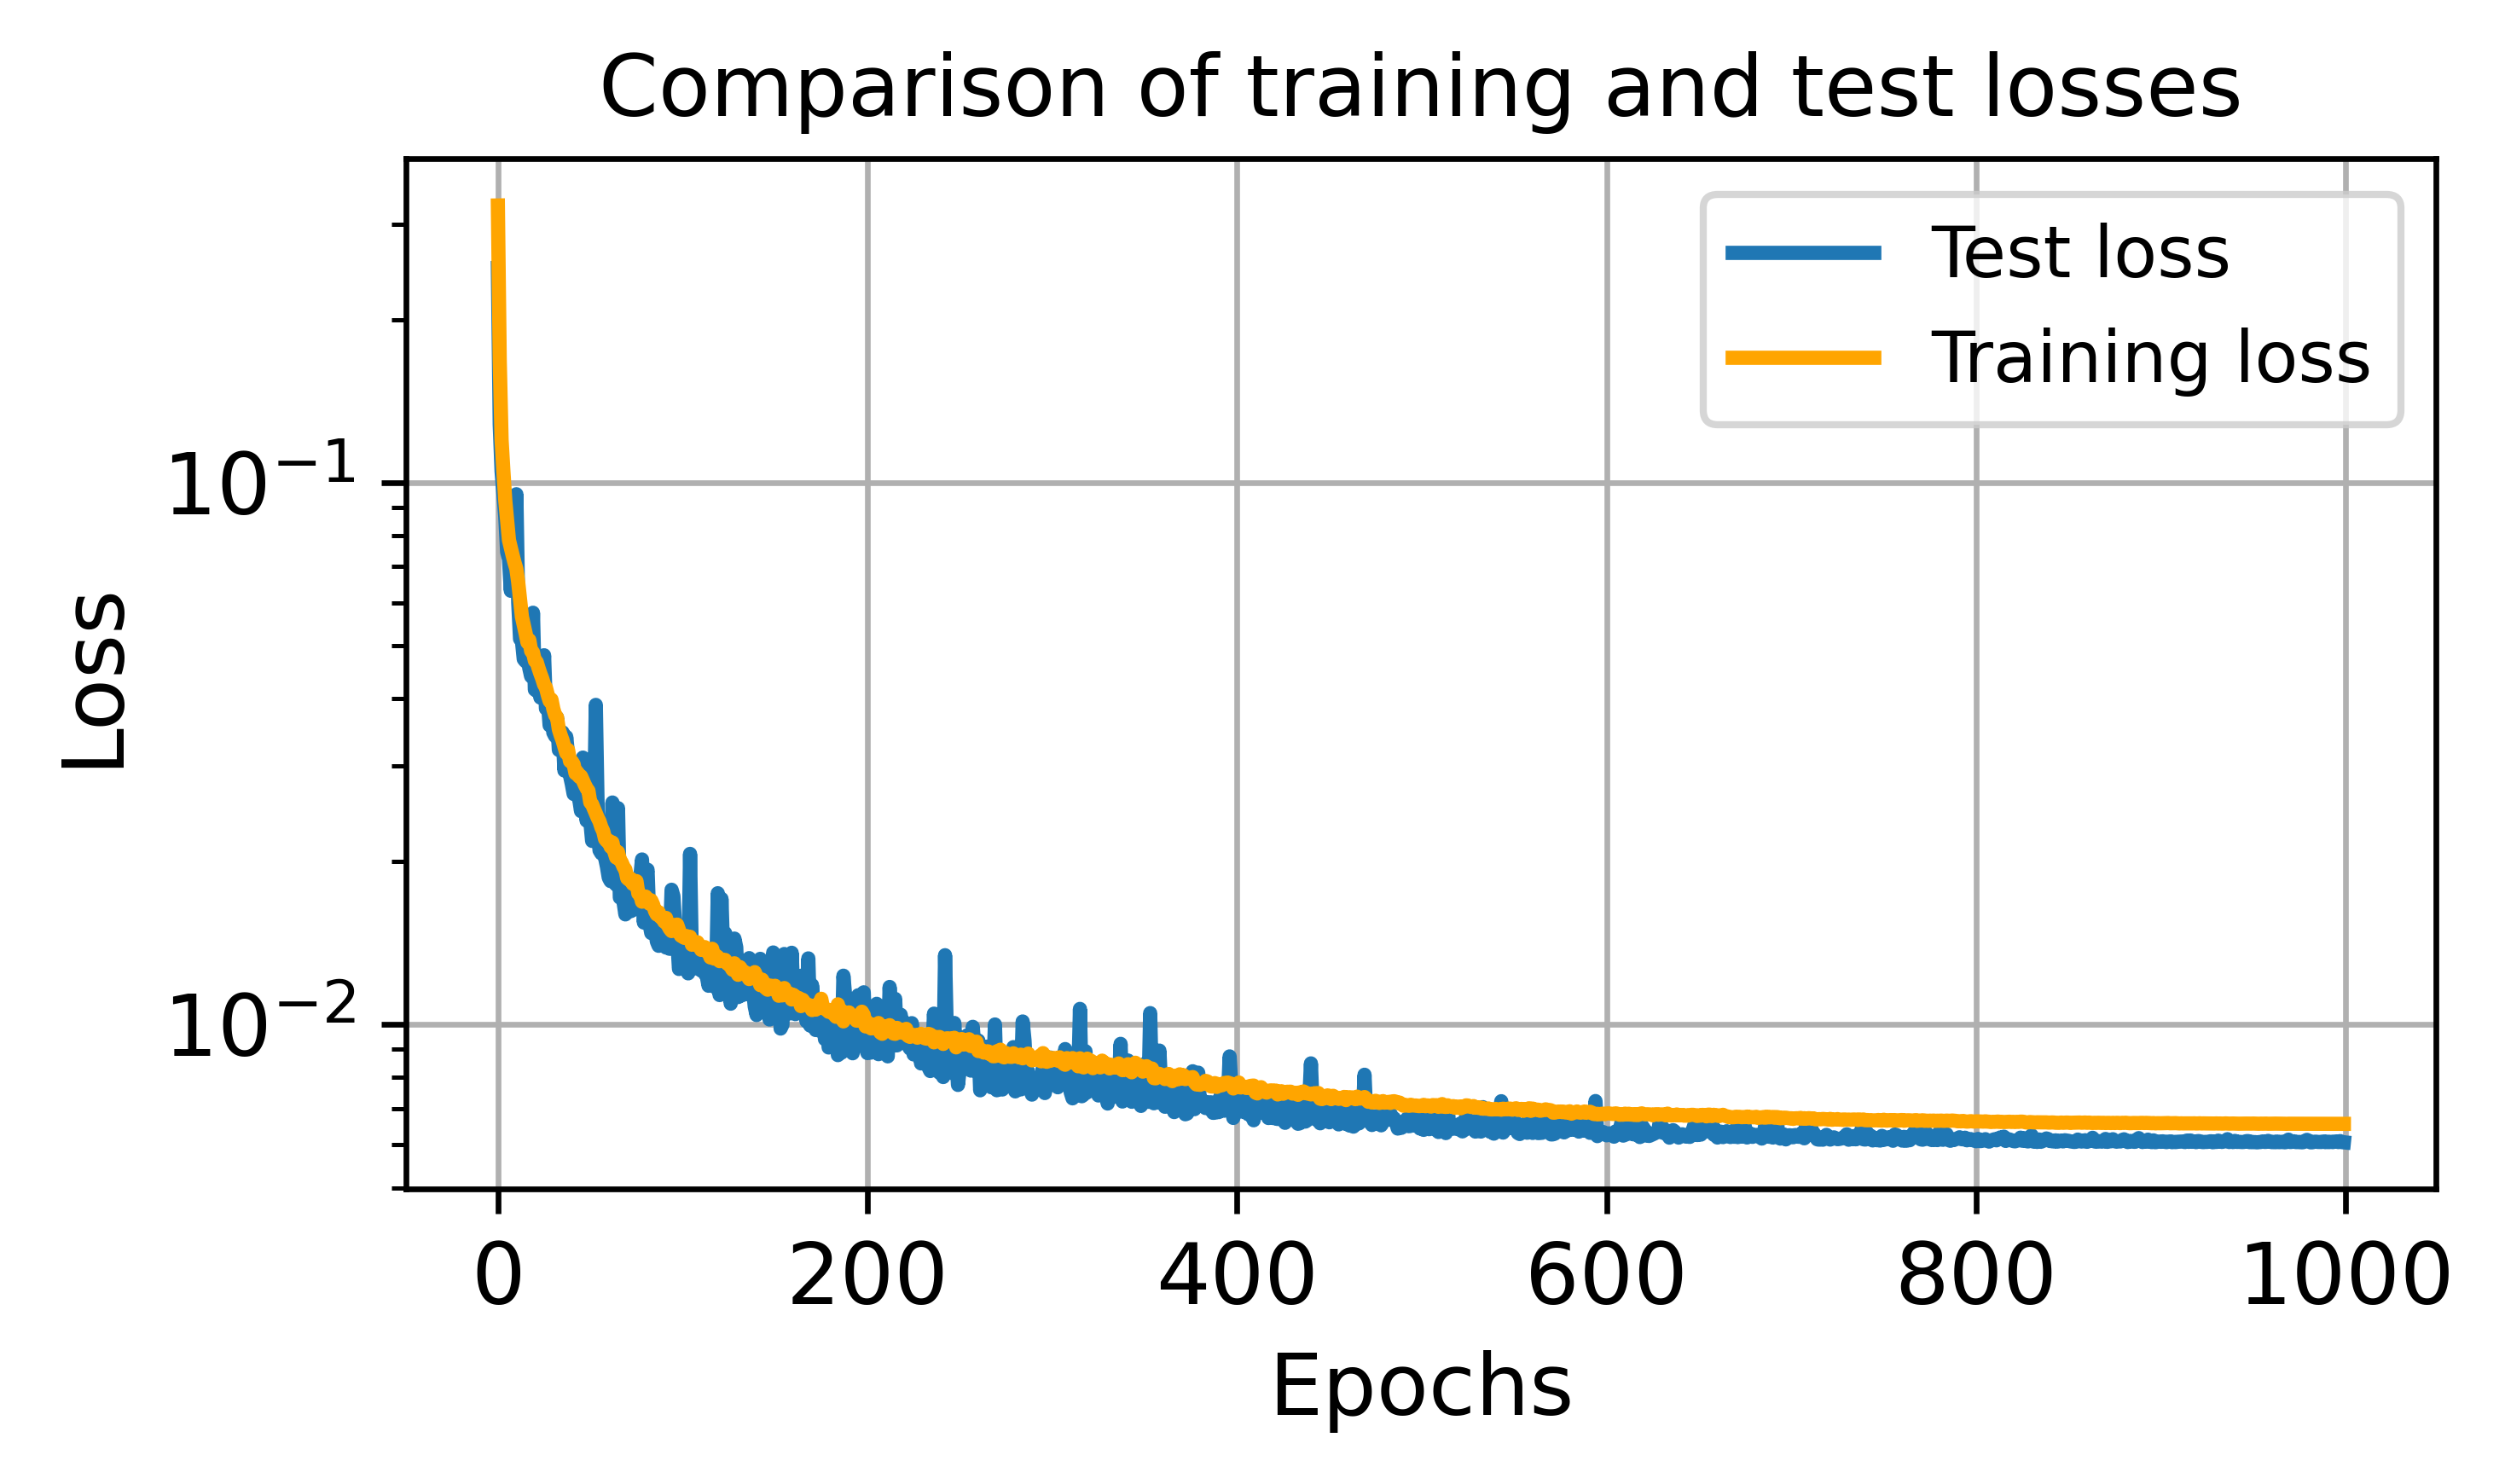

In [42]:
# Convergence history plot for verification

plt.style.use('default')
fig = plt.figure(figsize=(5, 3), dpi=600 )
ax = plt.axes()

ax.semilogy(test_loss, linewidth=2, label = 'Test loss')
ax.semilogy(train_loss , linewidth=2, label = 'Training loss', color = 'orange')

ax.set_xlabel('Epochs', fontsize=12)
plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(200))

ax.set_ylabel('Loss', fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.legend(loc='upper right')
plt.title('Comparison of training and test losses')

plt.tight_layout()

# plt.savefig( 'Loss_gradient_'+str(int(spacing*1000))+'m_m2w2.png' , dpi=600 )

plt.show()

In [60]:
# To load the model if available

# model_name = 'Model_gradient_50m_m2w2_best.pt'

# model.load_state_dict(torch.load(model_name))

model.eval()

FNO2d(
  (fc0): Linear(in_features=3, out_features=2, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [44]:
fsize = 12

def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet', 
                xlabel=True, ylabel=False, vmin=None, vmax=None):
    
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ax1, ax=AX)
    cbar.ax.tick_params(labelsize=fsize)
    
    if Xs and Ys:
        AX.scatter(Xs, Ys, marker='*', color='r', s = 100 )
        
    AX.set_title(title, size=fsize)

    AX.invert_yaxis()

    AX.tick_params(axis='both', which='major', labelsize=fsize )  # Set tick label fontsize
    
    if xlabel: AX.set_xlabel('Offset (km)', size=fsize)
    if ylabel: AX.set_ylabel('Depth (km)', size=fsize)

    AX.set_aspect(1)

In [45]:
XMIN, XMAX = 0, 3
YMIN, YMAX = 0, 2
XGRID = np.linspace(XMIN, XMAX, nx)
YGRID = np.linspace(YMIN, YMAX, nz)
XGRID, YGRID = np.meshgrid(XGRID, YGRID, indexing='ij')

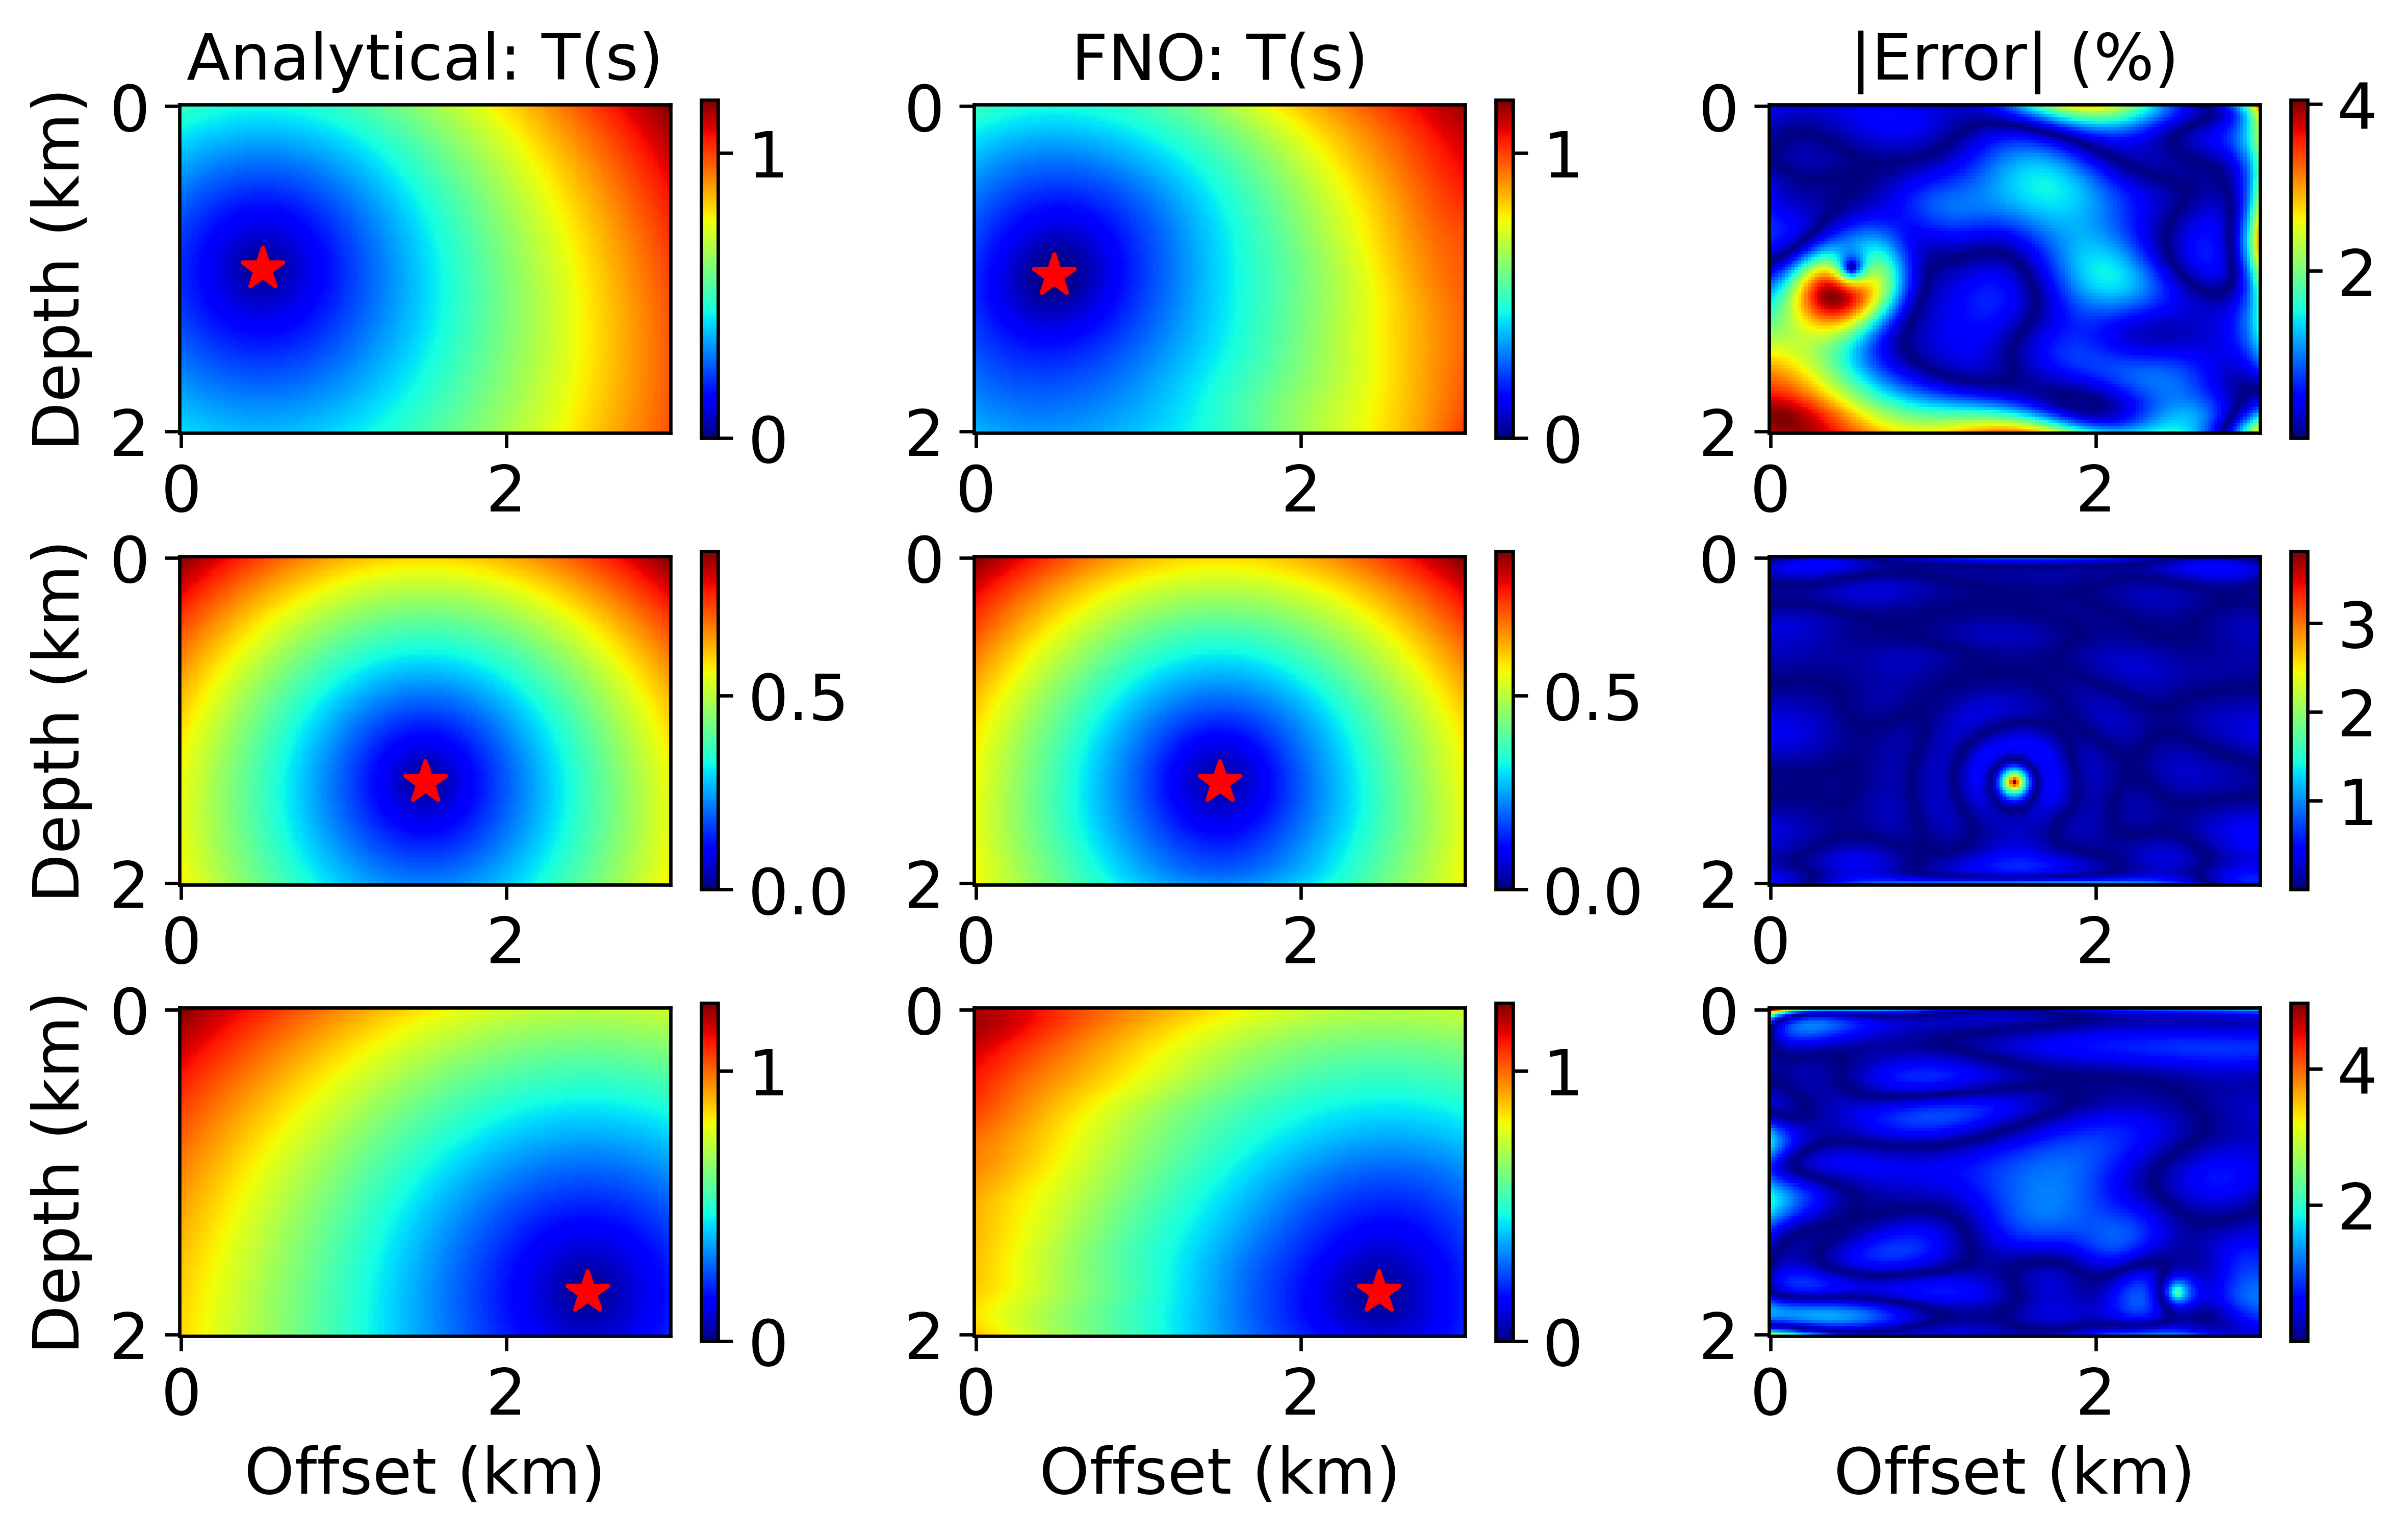

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(8,5), dpi = 600 )

x_test = XGRID.T
y_test = YGRID.T
batch_size = 1

for i, (xi, eta) in enumerate([(25, 50), (75, 69), (125, 87)]):

    vs = v0 + vergrad*y_test[eta,xi] + horgrad*x_test[eta,xi]    # velocity at the source location

    # for velocity gradient model
    T_data_y = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs) * (vergrad**2 + horgrad**2)*
                            ((X-x_test[eta,xi])**2 + (Z-y_test[eta,xi])**2)) / torch.sqrt(vergrad**2 + horgrad**2))
        
    T_data_x = T_data_y[0].clone()
    T_data_x = T_data_x.reshape(1,1,nx)
    T_data_x = T_data_x.repeat(1,nz,1)    
    T_data_x = T_data_x.reshape(1,nz,nx,1)    
    T_data_x = T_data_x.type( 'torch.FloatTensor' )
    T_data_x = T_data_x.cuda()

    out = model(T_data_x).reshape(batch_size, nz, nx)
    pred = out.cpu()
    pred = pred.reshape(nz, nx)
    ssz, ssx = np.where(pred == torch.min(pred))
    ss = (deltax*ssx[0], deltaz*ssz[0])

    exact = T_data_y.detach().numpy()
    x_source = x_test[eta,xi]
    y_source = y_test[eta,xi]
    
    pred = pred.detach().numpy()
    x_source_pred = ss[0]
    y_source_pred = ss[1]

    cust_pcolor(ax[i, 0], x_test, y_test, exact, x_source, y_source, 'Analytical: T(s)' if i==0 else None, 
                cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, pred, x_source_pred, y_source_pred, 'FNO: T(s)' if i==0 else None,
                'jet', vmin=exact.min(), vmax=exact.max(), xlabel=True if i==2 else False)
    
    error = abs(pred - exact) / exact.max() * 100
    cust_pcolor(ax[i, 2], x_test, y_test, error, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

plt.tight_layout()

# plt.savefig( 'gradient_preds-pub_'+str(int(spacing*1000))+'m_m2w2.png' , dpi=600 )

plt.show()

In [62]:
# Generate test set

cord_z_test = np.random.uniform( 1, 1.75, size=(1000) )
cord_x_test = np.random.uniform( 0.5, 2.5, size=(1000) )

T_data_y_test = torch.zeros([len(cord_z_test),nz,nx])

rmse_error = []
source_error = []

for i in range(len(cord_z_test)):

        vs = v0 + vergrad*cord_z_test[i] + horgrad*cord_x_test[i]    # velocity at the source location

        # for velocity gradient model
        T_data_y_test[i,:,:] = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs) * (vergrad**2 + horgrad**2)*
                                ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))

        T_data_x = T_data_y_test[i,0,:].clone()
        T_data_x = T_data_x.reshape(1,1,nx)
        T_data_x = T_data_x.repeat(1,nz,1)                    
        T_data_x = T_data_x.reshape(1,nz,nx,1)
        T_data_x = T_data_x.type( 'torch.FloatTensor' )
        T_data_x = T_data_x.cuda()
    
        out = model(T_data_x).reshape(batch_size, nz, nx)
        pred = out.cpu()
        pred = pred.reshape(nz, nx)
        ssz, ssx = np.where(pred == torch.min(pred))
        ss = ( deltax * ssx[0], deltaz * ssz[0] )

        exact = T_data_y_test[i,:,:].detach().numpy()
        x_source = cord_x_test[i]
        y_source = cord_z_test[i]
        
        pred = pred.detach().numpy()
        x_source_pred = ss[0]
        y_source_pred = ss[1]

        rmse_error.append( np.sqrt( np.mean( (exact - pred)**2 ) ) )
        source_error.append( [ x_source-x_source_pred, y_source-y_source_pred ] )
        

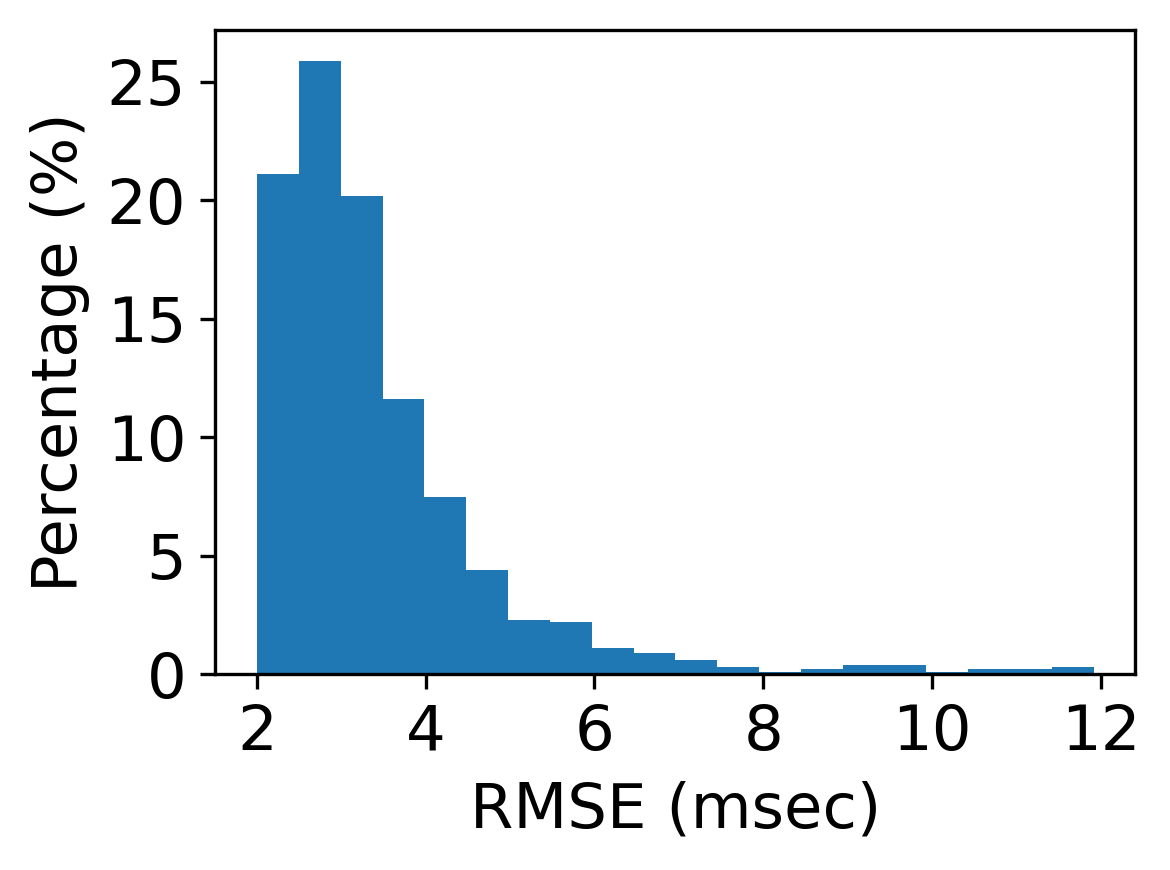

In [63]:
fsize = 15

rmse_error = np.array(rmse_error)
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100

plt.figure(figsize=(4,3), dpi = 300)

plt.hist(rmse_error*1000, 20, weights=weights)

plt.xlabel('RMSE (msec)',fontsize=fsize)
plt.ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()

# plt.savefig( 'gradient_RMSE_1000_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()

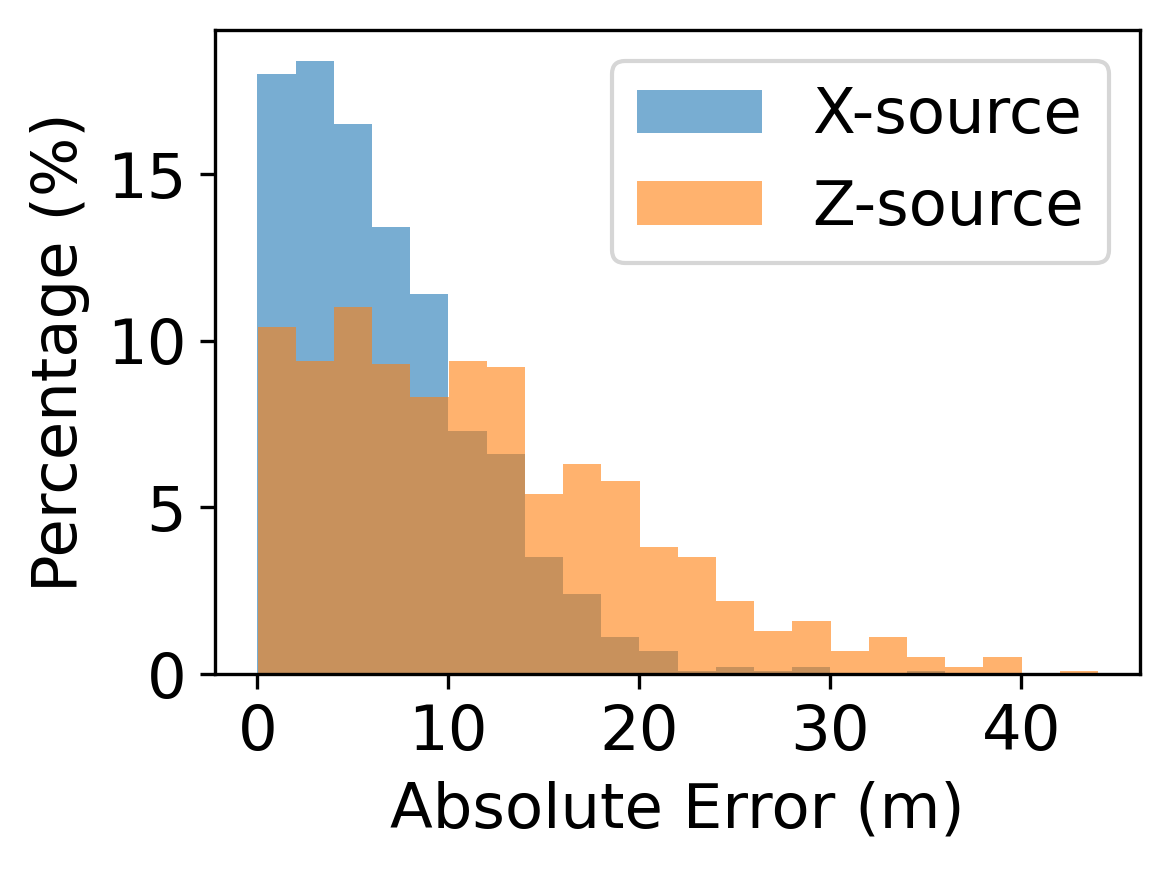

In [64]:
fsize = 15

weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi = 300)
ax = [ax]

# Desired bin width
bin_width = 2 # meters

for i in range(2) :

    data = abs(source_error[:, i])*1000
    
    # Define bin edges with a width of 2 meters
    bin_edges = np.arange( min(data), max(data) + bin_width, bin_width )

    # Create the histogram with exact bin edges
    ax[0].hist( data, bins=bin_edges, weights=weights, alpha=0.6 )

ax[0].set_xlabel('Absolute Error (m)',fontsize=fsize)
ax[0].set_ylabel('Percentage (%)',fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

ax[0].yaxis.set_major_locator(plt.MultipleLocator(5))

plt.tight_layout()
plt.legend( ['X-source', 'Z-source'], fontsize=fsize )

# plt.savefig( 'gradient_abs_errors_1000_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()

In [65]:
# Adding noise

NUM_TRIAL = 1000

cord_z_test = np.random.uniform( 1, 1.75, size=(NUM_TRIAL) )
cord_x_test = np.random.uniform( 0.5, 2.5, size=(NUM_TRIAL) )

T_data_y_test = torch.zeros([len(cord_z_test),nz,nx])
T_data_y_test_noisy = torch.zeros([len(cord_z_test),nz,nx])

noise_vals =  [ 0.01, 0.1, 0.2, 0.5 ]

noise_error = []
noise_source_error = []

for noise in noise_vals:
    
    rmse_error2 = []
    source_loc2 = []
    source_error2 = []

    # adding noise
    t_sensor = velmodel.clone()
    t_sensor += torch.randn(t_sensor.size())*noise*t_sensor.std()
    t_sensor = np.maximum(0., t_sensor)

    for i in range(NUM_TRIAL):

        vs = v0 + vergrad*cord_z_test[i] + horgrad*cord_x_test[i]    # velocity at the source location

        T_data_y_test[i,:,:] = (torch.arccosh(1.0 + 0.5*(1.0/velmodel)*(1/vs) * (vergrad**2 + horgrad**2)*
                                ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))

        # for noisy velocity gradient model (testing)
        T_data_y_test_noisy[i,:,:] = (torch.arccosh(1.0 + 0.5*(1.0/t_sensor)*(1/vs) * (vergrad**2 + horgrad**2)*
                                ((X-cord_x_test[i])**2 + (Z-cord_z_test[i])**2)) / torch.sqrt(vergrad**2 + horgrad**2))

        T_data_x_test = T_data_y_test_noisy[i,0,:].clone()
        T_data_x_test = T_data_x_test.reshape(1,1,nx)
        T_data_x_test = T_data_x_test.repeat(1,nz,1)
        T_data_x_test = T_data_x_test.reshape(1,nz,nx,1)      
        T_data_x_test = T_data_x_test.type( 'torch.FloatTensor' )
        T_data_x_test = T_data_x_test.cuda()
    
        out = model(T_data_x_test).reshape(batch_size, nz, nx)
        pred = out.cpu()
        pred = pred.reshape(nz, nx)
        ssz, ssx = np.where(pred == torch.min(pred))
        ss = (deltax*ssx[0], deltaz*ssz[0])

        exact = T_data_y_test[i,:,:].clone().detach().numpy()
        x_source = cord_x_test[i]
        y_source = cord_z_test[i]
        
        pred = pred.detach().numpy()
        x_source_pred = ss[0]
        y_source_pred = ss[1]
        
        rmse_error2.append( np.sqrt( np.mean( (exact - pred)**2 ) ) )        
        source_loc2.append( [x_source, y_source] )        
        source_error2.append( [ x_source-x_source_pred, y_source-y_source_pred ] )
        
    print(f'done with noise = {noise}')
    noise_error.append(rmse_error2)
    noise_source_error.append(source_error2)

done with noise = 0.01
done with noise = 0.1
done with noise = 0.2
done with noise = 0.5


In [66]:
noise_source_error = np.array(noise_source_error)
noise_error = np.array(noise_error)
noise_Xsource_error = noise_source_error[:,:,0]
noise_Ysource_error = noise_source_error[:,:,1]

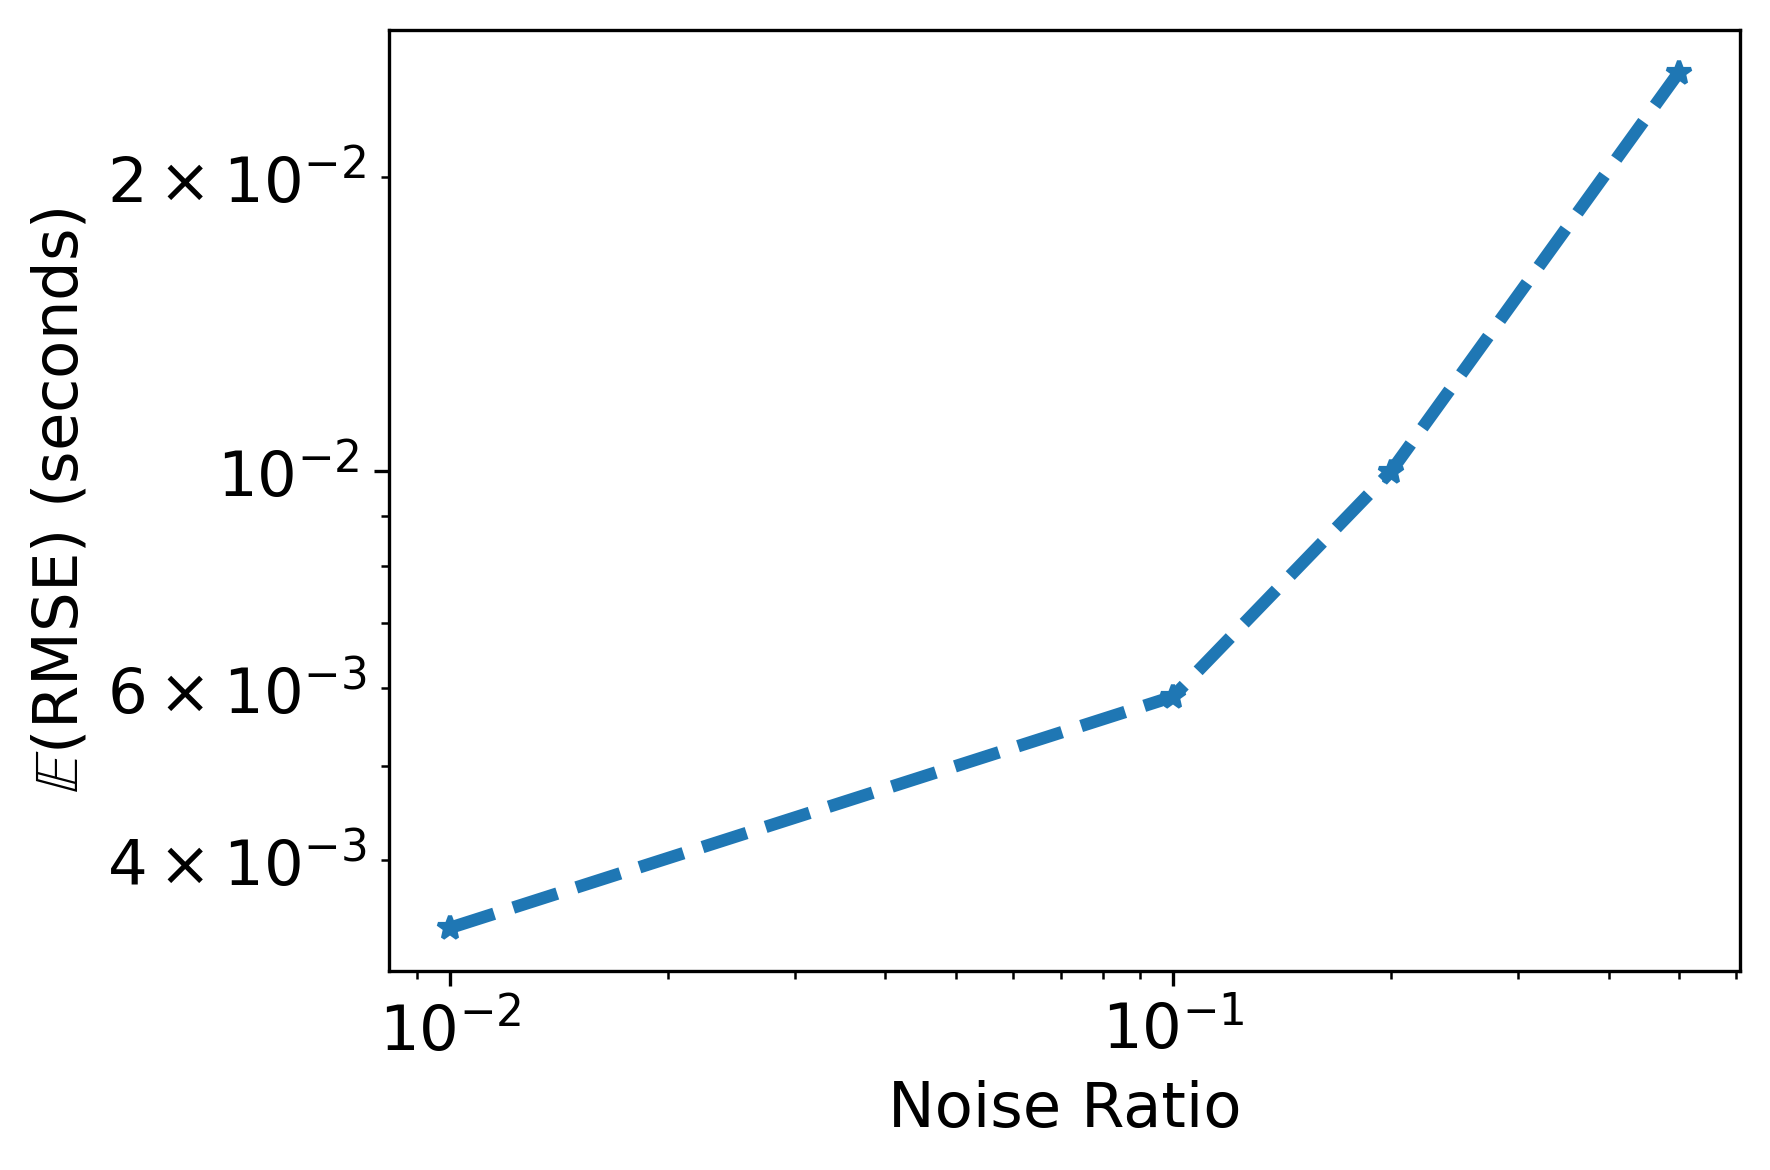

In [67]:
fsize = 15

plt.figure( figsize=( 6,4 ), dpi=300 )

plt.loglog( noise_vals, np.mean(noise_error, axis=-1), '--*', linewidth=3 )

plt.xlabel('Noise Ratio', fontsize=fsize)
plt.ylabel('$\mathbb{E}$(RMSE) (seconds)', fontsize=fsize)

plt.xticks(fontsize=fsize)

# Get the current Axes instance
ax = plt.gca()

# Set the font size of y-axis tick labels
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fsize)
for tick in ax.yaxis.get_minor_ticks():
    tick.label1.set_fontsize(fsize)

plt.tight_layout()

# plt.savefig( 'gradient_source_noise_sensitivity_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()

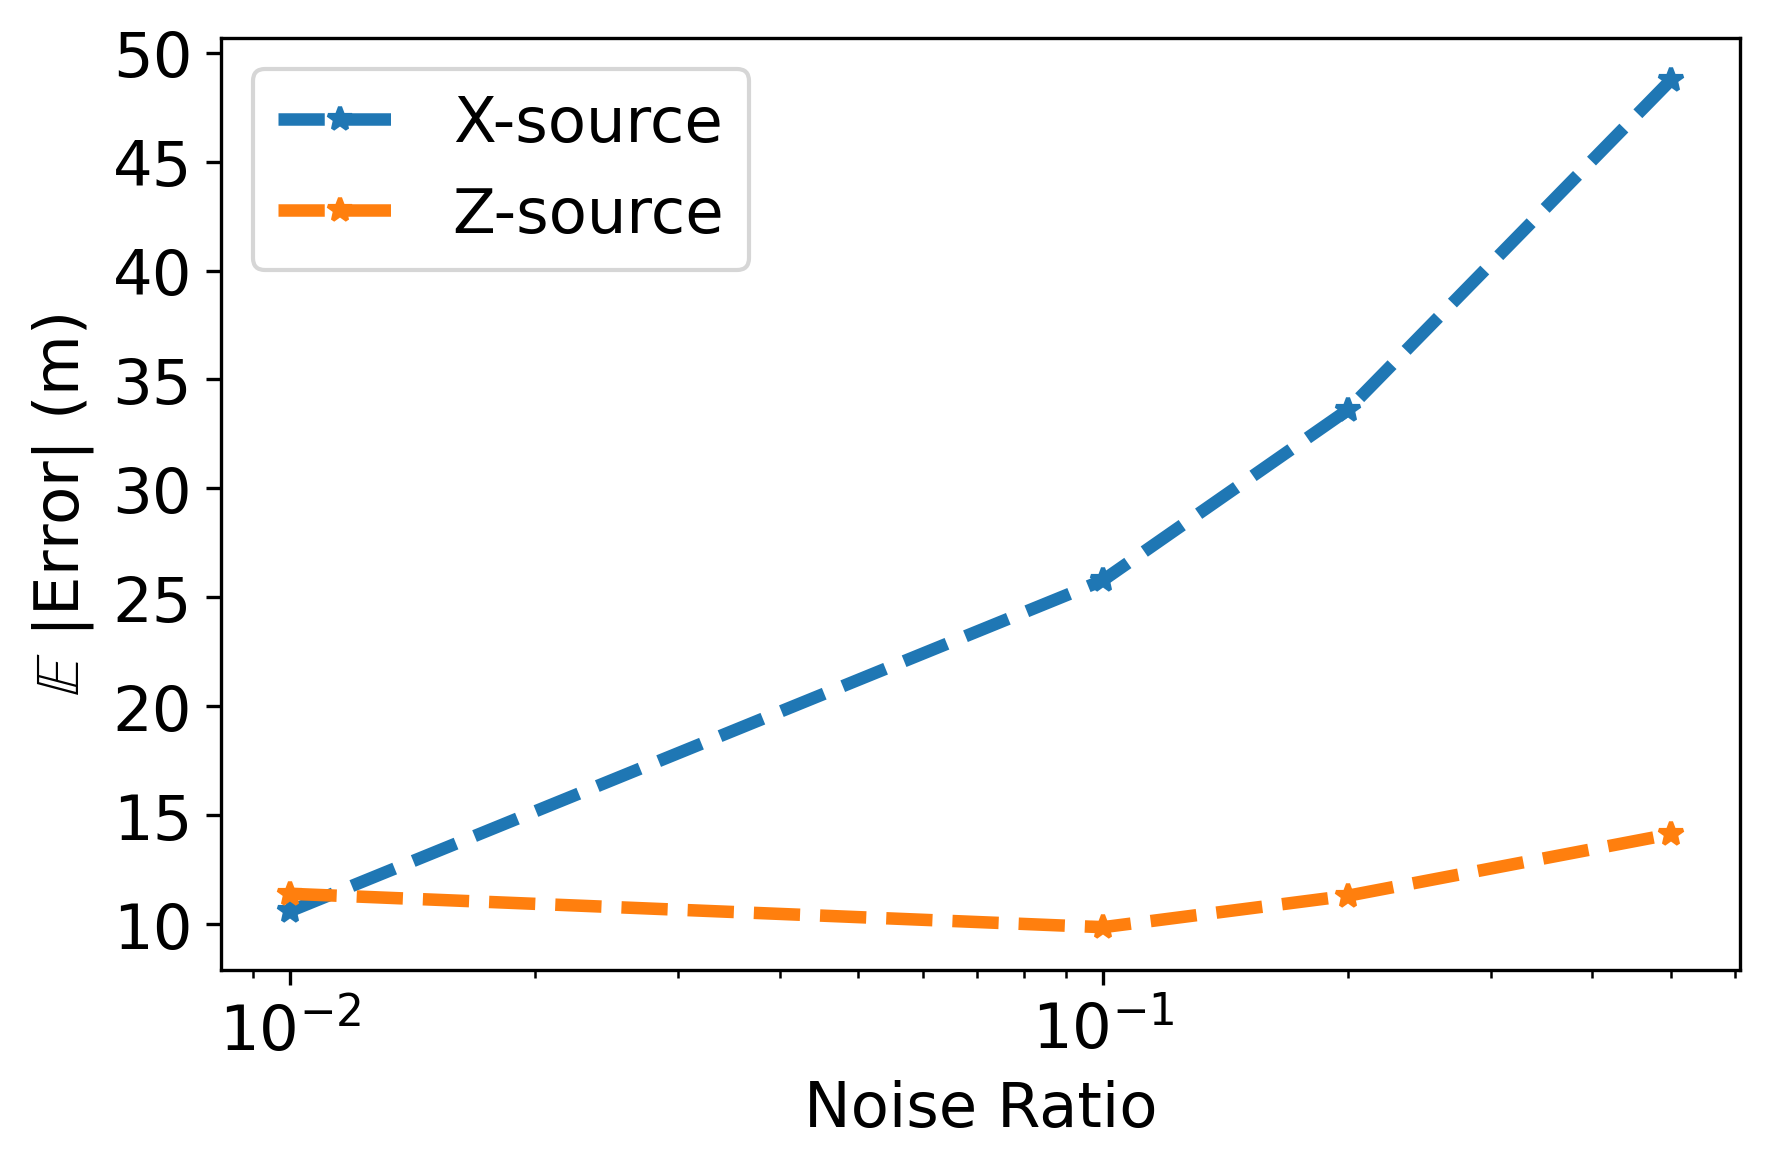

In [68]:
fsize = 15

plt.figure( figsize=(6,4), dpi=300 )

plt.semilogx(noise_vals, abs(noise_Xsource_error).mean(axis=-1)*1000, '--*', label='X-source', linewidth=3)
plt.semilogx(noise_vals, abs(noise_Ysource_error).mean(axis=-1)*1000, '--*', label='Z-source', linewidth=3)

plt.xlabel('Noise Ratio', fontsize=fsize)
plt.ylabel('$\mathbb{E}$ |Error| (m)', fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.legend(fontsize=fsize)
plt.tight_layout()

# plt.savefig( 'gradient_XY-source_noise_sensitivity_'+str(int(spacing*1000))+'m_m2w2.pdf' , dpi=300 )

plt.show()

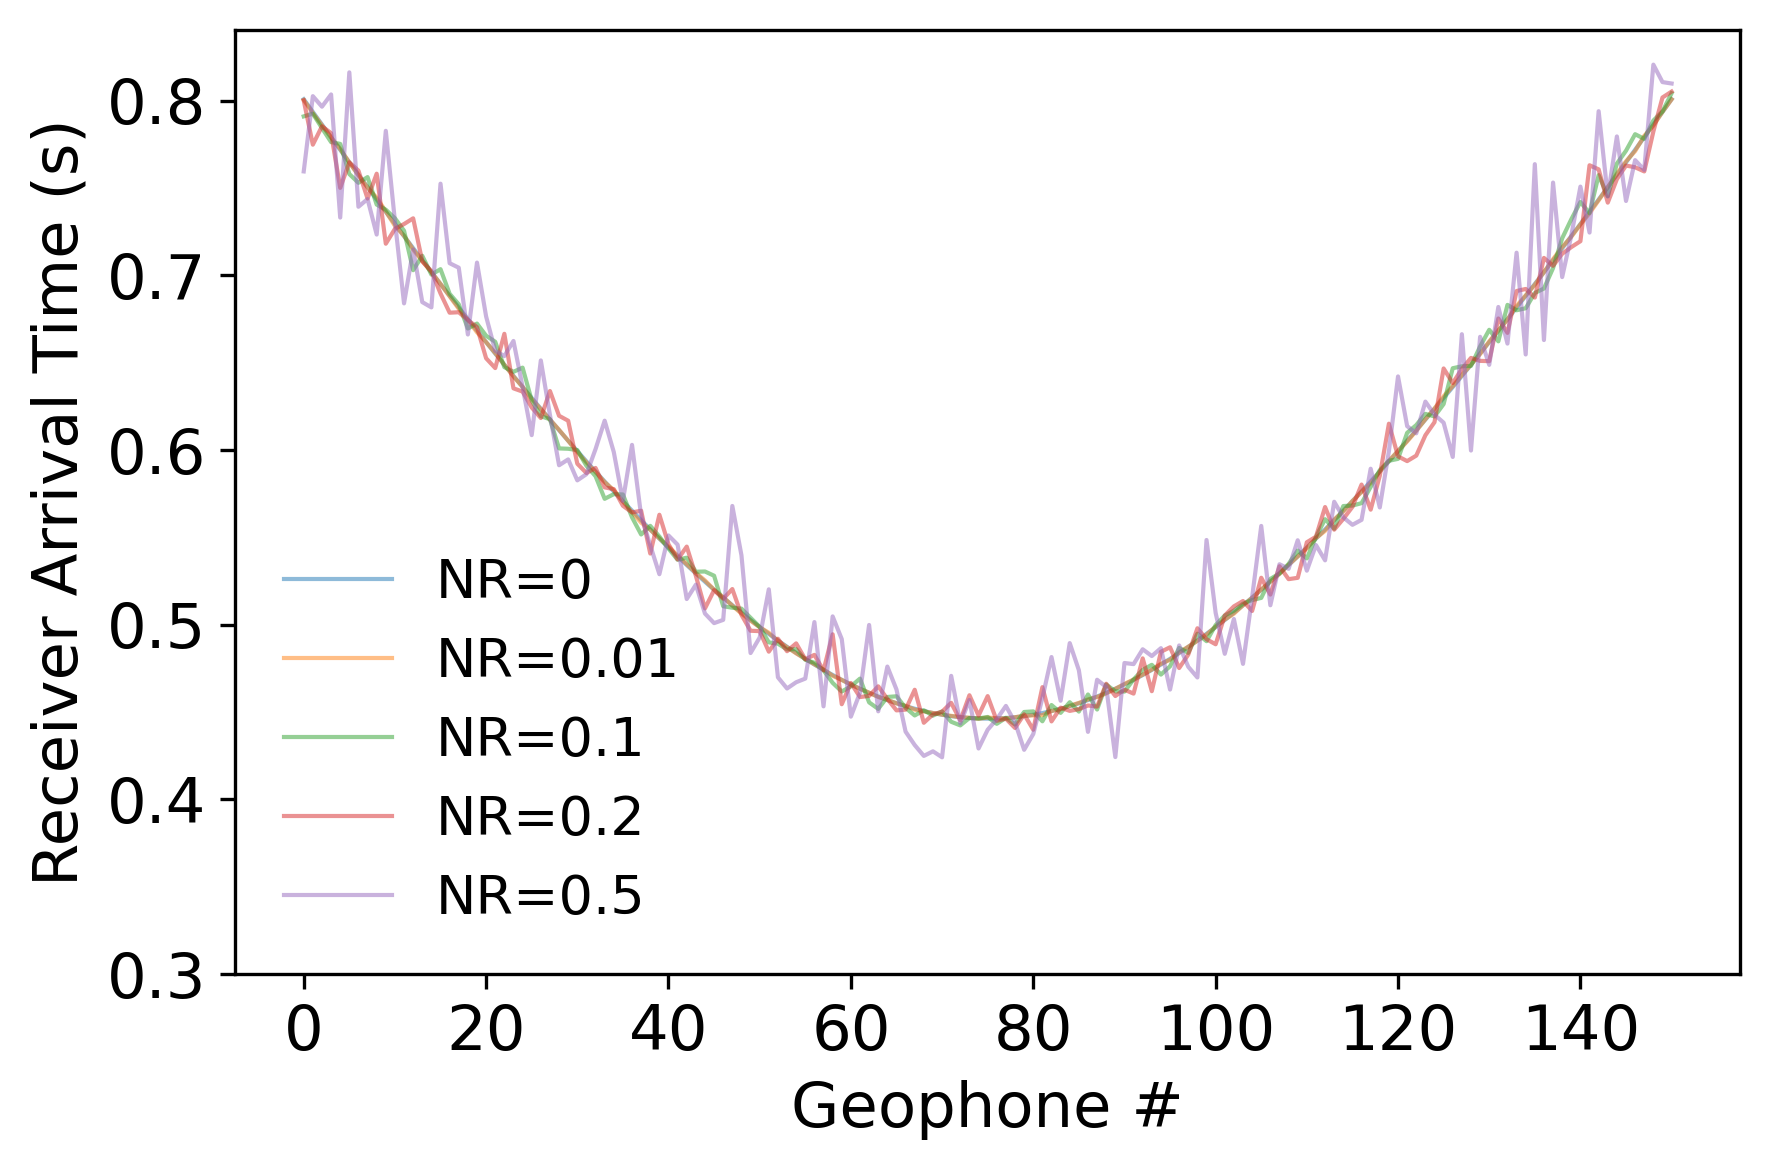

In [58]:
fsize = 15

fig = plt.figure( figsize=( 6,4 ), dpi=300 )

sensor_id = np.arange(0, nx, 1)

XMIN, XMAX = 0, 3
YMIN, YMAX = 0, 2
x_source = (XMIN + XMAX)/2
y_source = (YMIN + YMAX)/2
vs = v0 + vergrad*y_source + horgrad*x_source    # velocity at the source location      

for noise in [0, 0.01, 0.1, 0.2, 0.5]:

    t_sensor = velmodel.clone()
    t_sensor += torch.randn(t_sensor.size())*noise*velmodel.std()
    t_sensor = np.maximum(0., t_sensor)

    # for noisy velocity gradient model (testing)
    T_data_y_syn = (torch.arccosh(1.0 + 0.5*(1.0/t_sensor)*(1/vs) * (vergrad**2 + horgrad**2)*
                            ((X-x_source)**2 + (Z-y_source)**2)) / torch.sqrt(vergrad**2 + horgrad**2))

    T_data_x_syn = T_data_y_syn[0].clone()
    
    plt.plot(sensor_id, T_data_x_syn[sensor_id], '-', label=f'NR={noise}', alpha=0.5, lw=1 )
        
plt.ylim(0.3, None)

plt.ylabel('Receiver Arrival Time (s)', fontsize=fsize)
plt.xlabel('Geophone #', fontsize=fsize)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.tight_layout()
plt.legend(title="noise ratio", loc='lower left', frameon=False, fontsize=fsize-1)
plt.legend(loc='lower left', frameon=False, fontsize=fsize-2)

# plt.savefig( 'gradient_recevier-noise-realizations.pdf' , dpi=300 )

plt.show()